In [5]:
#mounting gdrive to colab in order to get the images
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## **Imports**:

In [1]:
#imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean
from sklearn.model_selection import train_test_split
import os
import matplotlib.image as mpimg
from skimage.io import imsave
import re
import pandas as pd
from albumentations import VerticalFlip, HorizontalFlip, RandomRotate90, Transpose, ShiftScaleRotate, RandomSizedCrop

#tensorflow and keras
from keras.models import Model, load_model
import tensorflow as tf
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import optimizers
from keras.layers import BatchNormalization
from tensorflow.keras.metrics import MeanIoU
import keras
from keras import backend as K
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from datetime import datetime

Using TensorFlow backend.


## **Data Processing**:

In [0]:
training_img_path  = '/content/gdrive/My Drive/cil_road_segmentation/training/images/satImage_'
training_img_truth = '/content/gdrive/My Drive/cil_road_segmentation/training/groundtruth/satImage_'

IMG_HEIGHT = 400
IMG_WIDTH  = 400

In [0]:
#training images
training_images = []
groundtruths = []
names = []

for i in range(1, 101):
  names.append('satImage_' + '%.3d' % i + '.png')
  training_images.append(resize(io.imread(training_img_path + '%.3d' % i + '.png'), (IMG_HEIGHT, IMG_WIDTH)))
  groundtruths.append(resize(io.imread(training_img_truth + '%.3d' % i + '.png', as_gray= True), (IMG_HEIGHT, IMG_WIDTH)))

In [8]:
#splitting data to evaluate it later
labels = np.expand_dims(np.array(groundtruths), -1)

random_state = 101

train_imgs, val_imgs, train_labs, val_labs, train_names, val_names = train_test_split(np.array(training_images), np.array(labels), np.array(names), test_size= 0.2, random_state= random_state)
print("Number of training images: {}; Number of testing images: {};".format(train_imgs.shape[0], val_imgs.shape[0]))

Number of training images: 80; Number of testing images: 20;


In [9]:
#save the validation pictures
def save_predictions_png(names, images, path):
    """creates predictions mask pngs"""
    for i, name in enumerate(names):
        imsave(path + name, images[i])

val_path = '/content/gdrive/My Drive/cil_road_segmentation/evaluation/images/'
if not os.path.exists(val_path):
  os.makedirs(val_path)

save_predictions_png(val_names, val_imgs, val_path)

In [0]:
#images paths
test_names = os.listdir(val_path)

In [0]:
#reading all the images
test_images = []

for name in test_names:
  test_images.append(resize(io.imread(val_path + name), (IMG_HEIGHT, IMG_WIDTH)))

In [0]:
#turning the pictures array into numpy ones
test_imgs  = np.array(test_images)

In [0]:
#function to visualize data: original parameters will be used later in data augmentation
def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 18
    mask = mask.reshape(IMG_HEIGHT, IMG_WIDTH)
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(2, 1, figsize=(8, 8))

        ax[0].imshow(image)
        ax[1].imshow(mask, cmap= 'gray')
    else:
        original_mask = original_mask.reshape(IMG_HEIGHT, IMG_WIDTH)
        f, ax = plt.subplots(2, 2, figsize=(8, 8))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)
        
        ax[1, 0].imshow(original_mask, cmap= 'gray')
        ax[1, 0].set_title('Original mask', fontsize=fontsize)
        
        ax[0, 1].imshow(image)
        ax[0, 1].set_title('Transformed image', fontsize=fontsize)
        
        ax[1, 1].imshow(mask, cmap= 'gray')
        ax[1, 1].set_title('Transformed mask', fontsize=fontsize)

Shapes: (400, 400, 3) - (400, 400, 1);


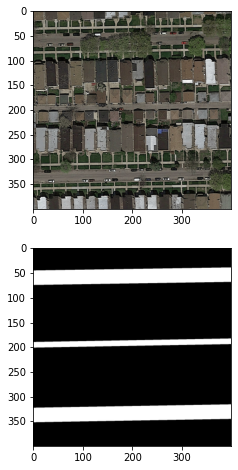

In [16]:
#display a random image to check if the images were read correctly
to_display = np.random.randint(100)

visualize(train_imgs[to_display], train_labs[to_display])

print("Shapes: {} - {};".format(train_imgs[to_display].shape, train_labs[to_display].shape))

## **Data Augmentation**:

In [0]:
h_flipped_imgs, h_flipped_labs   = [], []
v_flipped_imgs, v_flipped_labs   = [], []
r_rotated_imgs, r_rotated_labs   = [], []
s_rotated_imgs, s_rotated_labs   = [], []

aug_probab = 1.0

h_flipper  = HorizontalFlip(p = aug_probab)
v_flipper  = VerticalFlip(p= aug_probab)
r_rotater  = RandomRotate90(p= aug_probab)
s_rotater  = ShiftScaleRotate(p= aug_probab)

for t_image, t_mask in zip(train_imgs, train_labs):
  h = h_flipper(image= t_image, mask= t_mask)
  v = v_flipper(image= t_image, mask= t_mask)
  r = r_rotater(image= t_image, mask= t_mask)
  s = s_rotater(image= t_image, mask= t_mask)

  if not np.allclose(h['image'], t_image):
    h_flipped_imgs.append(h['image'])
    h_flipped_labs.append(h['mask'])

  if not np.allclose(v['image'], t_image):
    v_flipped_imgs.append(v['image'])
    v_flipped_labs.append(v['mask'])
  
  if not np.allclose(r['image'], t_image):
    r_rotated_imgs.append(r['image'])
    r_rotated_labs.append(r['mask'])

  if not np.allclose(s['image'], t_image):
    s_rotated_imgs.append(s['image'])
    s_rotated_labs.append(s['mask'])

In [0]:
aug_train_imgs = np.vstack((train_imgs,
                           np.array(h_flipped_imgs),
                           np.array(v_flipped_imgs),
                           np.array(r_rotated_imgs),
                           np.array(s_rotated_imgs)))

aug_train_labs = np.vstack((train_labs,
                           np.array(h_flipped_labs),
                           np.array(v_flipped_labs),
                           np.array(r_rotated_labs),
                           np.array(s_rotated_labs)))

In [0]:
#shuffling the two arrays to not have every set of augmentation stacked on another
indices = np.arange(aug_train_imgs.shape[0])
np.random.shuffle(indices)

aug_train_imgs = aug_train_imgs[indices]
aug_train_labs = aug_train_labs[indices]

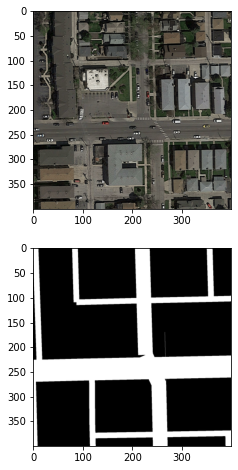

In [42]:
randint = np.random.randint(aug_train_imgs.shape[0])
visualize(aug_train_imgs[randint], aug_train_labs[randint])

In [43]:
aug_train_imgs.shape, aug_train_labs.shape

((377, 400, 400, 3), (377, 400, 400, 1))

### Visualization of transformations:

#### Vertical Flip:

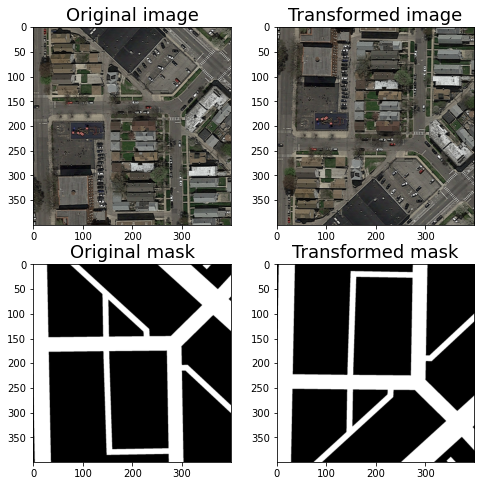

In [0]:
randindex = np.random.randint(train_imgs.shape[0])
img, msk = train_imgs[randindex], train_labs[randindex]
box = VerticalFlip(p=1) (image= img, mask= msk)
img_aug, msk_aug = box['image'], box['mask']
visualize(img_aug, msk_aug, img, msk)

#### Horizontal Flip:

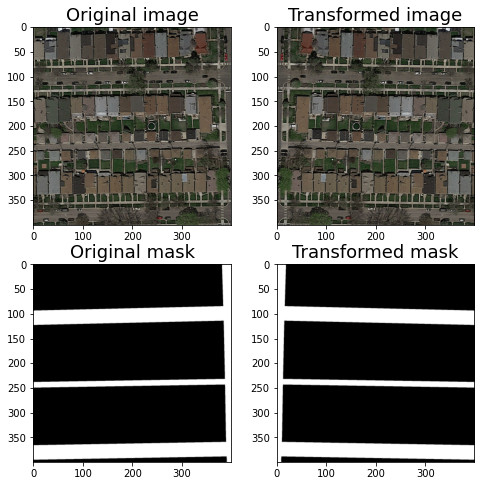

In [0]:
randindex = np.random.randint(train_imgs.shape[0])
img, msk = train_imgs[randindex], train_labs[randindex]
box = HorizontalFlip(p=1) (image= img, mask= msk)
img_aug, msk_aug = box['image'], box['mask']
visualize(img_aug, msk_aug, img, msk)

#### RandomRotate90:

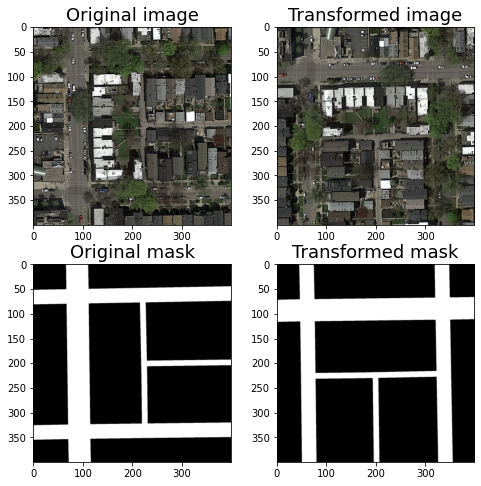

In [0]:
randindex = np.random.randint(train_imgs.shape[0])
img, msk = train_imgs[randindex], train_labs[randindex]
box = RandomRotate90(p=1) (image= img, mask= msk)
img_aug, msk_aug = box['image'], box['mask']
visualize(img_aug, msk_aug, img, msk)

#### ShiftScaleRotate:

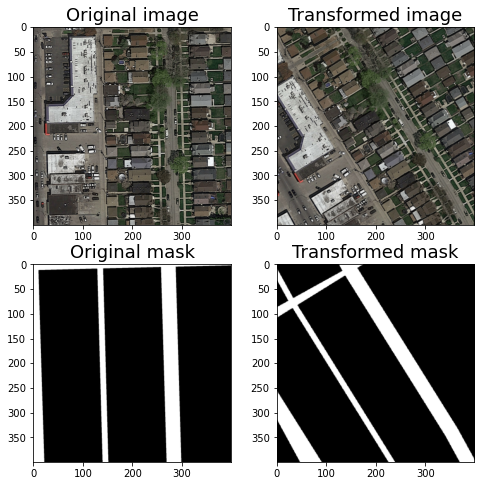

In [0]:
randindex = np.random.randint(train_imgs.shape[0])
img, msk = train_imgs[randindex], train_labs[randindex]
box = ShiftScaleRotate(p=1) (image= img, mask= msk)
img_aug, msk_aug = box['image'], box['mask']
visualize(img_aug, msk_aug, img, msk)

## **Model**:

In [0]:
#defining some custom loss functions and accuracy metrics in order to evaluate the model inside the jupyter notebook
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  
  return iou

def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def soft_dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [60]:
inputs = Input((IMG_HEIGHT, IMG_WIDTH, 3))
s = Lambda(lambda x: x / 255) (inputs)

def convLevel(filters, kernel_size, dropout, input_vec):
  conv = Conv2D(filters, kernel_size, activation= 'elu', kernel_initializer= 'he_normal', padding= 'same') (input_vec)
  conv = BatchNormalization() (conv)
  conv = Dropout(dropout) (conv)
  conv = Conv2D(filters, kernel_size, activation= 'elu', kernel_initializer= 'he_normal', padding= 'same') (conv)
  conv = BatchNormalization() (conv)
  return conv

conv1 = convLevel(16, (3, 3), 0.1, inputs)
layer_1 = MaxPooling2D((2, 2)) (conv1)

conv2 = convLevel(32, (3, 3), 0.1, layer_1)
layer_2 = MaxPooling2D((2, 2)) (conv2)

conv3 = convLevel(64, (3, 3), 0.2, layer_2)
layer_3 = MaxPooling2D((2, 2)) (conv3)

conv4 = convLevel(128, (3, 3), 0.2, layer_3)
layer_4 = MaxPooling2D((2, 2)) (conv4)

conv5 = convLevel(256, (3, 3), 0.3, layer_4)

def convLevelTranspose(filters, dropout, input_vec, to_concatenate, axis= -1):
  upsample = Conv2DTranspose(filters, (2, 2), strides= (2, 2), padding= 'same') (input_vec)
  upsample = concatenate([upsample, to_concatenate], axis= axis)

  conv = Conv2D(filters, (3, 3), activation= 'elu', kernel_initializer= 'he_normal', padding= 'same') (upsample)
  conv = BatchNormalization() (conv)
  conv = Dropout(dropout) (conv)
  conv = Conv2D(filters, (3, 3), activation= 'elu', kernel_initializer= 'he_normal', padding= 'same') (conv)
  conv = BatchNormalization() (conv)
  return conv

conv6 = convLevelTranspose(128, 0.2, conv5, conv4)
conv7 = convLevelTranspose(64, 0.2, conv6, conv3)
conv8 = convLevelTranspose(32, 0.2, conv7, conv2)
conv9 = convLevelTranspose(32, 0.2, conv8, conv1, 3)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (conv9)

model = Model(inputs= [inputs], outputs= [outputs])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 400, 400, 3)  0                                            
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 400, 400, 16) 448         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_37 (BatchNo (None, 400, 400, 16) 64          conv2d_39[0][0]                  
__________________________________________________________________________________________________
dropout_19 (Dropout)            (None, 400, 400, 16) 0           batch_normalization_37[0][0]     
____________________________________________________________________________________________

In [0]:
#hyperparameters
EPOCHS = 350
L_RATE = 0.00001
B_SIZE = 16

In [0]:
optimizer = keras.optimizers.adam(L_RATE)
model.compile(optimizer= optimizer, loss= soft_dice_loss, metrics= [iou_coef, dice_coef])

In [82]:
history = model.fit(aug_train_imgs, 
                    aug_train_labs/255, 
                    validation_split= 0.1, 
                    epochs= EPOCHS, 
                    batch_size= B_SIZE)

Train on 339 samples, validate on 38 samples
Epoch 1/50
339/339 [==============================] - 18s 52ms/step - loss: 0.9935 - iou_coef: 0.0032 - dice_coef: 0.0066 - val_loss: 0.9941 - val_iou_coef: 0.0029 - val_dice_coef: 0.0060
Epoch 2/50
339/339 [==============================] - 12s 35ms/step - loss: 0.9935 - iou_coef: 0.0032 - dice_coef: 0.0066 - val_loss: 0.9940 - val_iou_coef: 0.0030 - val_dice_coef: 0.0060
Epoch 3/50
339/339 [==============================] - 12s 35ms/step - loss: 0.9935 - iou_coef: 0.0032 - dice_coef: 0.0066 - val_loss: 0.9940 - val_iou_coef: 0.0029 - val_dice_coef: 0.0060
Epoch 4/50
339/339 [==============================] - 12s 35ms/step - loss: 0.9935 - iou_coef: 0.0032 - dice_coef: 0.0065 - val_loss: 0.9940 - val_iou_coef: 0.0029 - val_dice_coef: 0.0060
Epoch 5/50
339/339 [==============================] - 12s 35ms/step - loss: 0.9935 - iou_coef: 0.0032 - dice_coef: 0.0065 - val_loss: 0.9940 - val_iou_coef: 0.0030 - val_dice_coef: 0.0061
Epoch 6/50
339/

## **Model evaluation**

In [0]:
preds = model.predict(val_imgs).reshape((-1, IMG_HEIGHT, IMG_WIDTH))

In [0]:
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

# assign a label to a patch
def patch_to_label(patch):
    df = np.mean(patch)
    if df > foreground_threshold:
        return 1
    else:
        return 0


def mask_to_submission_strings(image_filename):
    """Reads a single image and outputs the strings that should go into the submission file"""
    img_number = int(re.search(r"\d+", image_filename).group(0))
    im = mpimg.imread(image_filename)
    patch_size = 16
    for j in range(0, im.shape[1], patch_size):
        for i in range(0, im.shape[0], patch_size):
            patch = im[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch)
            yield("{:03d}_{}_{},{}".format(img_number, j, i, label))


def masks_to_submission(submission_filename, *image_filenames):
    """Converts images into a submission file"""
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for fn in image_filenames[0:]:
            f.writelines('{}\n'.format(s) for s in mask_to_submission_strings(fn))

def save_predictions_png(names, images, path):
    """creates predictions mask pngs"""
    for i, name in enumerate(names):
        imsave(path + name, images[i])

def make_csv(names, preds, submission_filename, path):
    save_predictions_png(names, preds, path)
    image_filenames = []
    for i, name in enumerate(names):
        image_filename = path + name
        image_filenames.append(image_filename)
    masks_to_submission(submission_filename, *image_filenames)

def make_groundtruth(names, groundtruth_filename):
    image_filenames = []
    for i, name in enumerate(names):
        image_filename = '/content/gdrive/My Drive/cil_road_segmentation/training/groundtruth/' + name
        image_filenames.append(image_filename)
    masks_to_submission(groundtruth_filename, *image_filenames)

In [123]:
pred_names = val_names

dirs_path = '/content/gdrive/My Drive/cil_road_segmentation/evaluation/predictions/'
if not os.path.exists(dirs_path):
  os.makedirs(dirs_path)

csv_path = '/content/gdrive/My Drive/cil_road_segmentation/evaluation/predictions.csv'
groundtruth_csv_path = '/content/gdrive/My Drive/cil_road_segmentation/evaluation/groundtruth.csv'
make_csv(pred_names, preds, csv_path, dirs_path)
make_groundtruth(pred_names, groundtruth_csv_path)
submission_df = pd.DataFrame(pd.read_csv(csv_path))
groundtruth_df = pd.DataFrame(pd.read_csv(groundtruth_csv_path))

In [124]:
from sklearn.metrics import accuracy_score

accuracy_score(groundtruth_df['prediction'], submission_df['prediction'])

0.9012

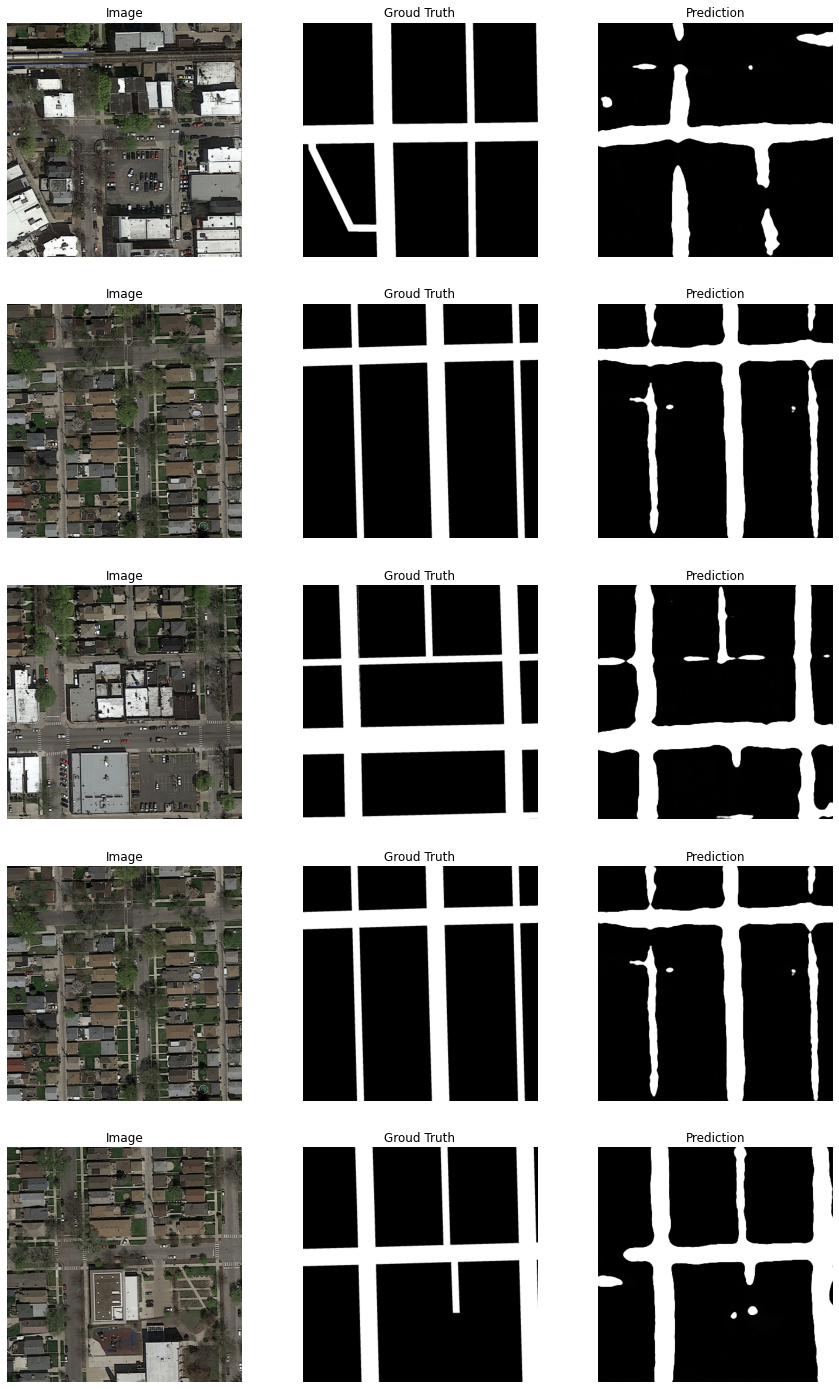

In [125]:
imgs = val_imgs
msks = val_labs

num_samples = 5

f = plt.figure(figsize= (15, 25))
for i in range(1, num_samples*3, 3):
  img = np.random.randint(preds.shape[0])

  f.add_subplot(num_samples, 3, i)
  imshow(imgs[img])
  plt.title("Image")
  plt.axis('off')

  f.add_subplot(num_samples, 3, i+1)
  imshow(np.squeeze(msks[img]), cmap= 'gray')
  plt.title("Groud Truth")
  plt.axis('off')

  f.add_subplot(num_samples, 3, i+2)
  imshow(preds[img]*255, cmap= 'gray')
  plt.title("Prediction")
  plt.axis('off')


In [0]:
testing_img_path   = '/content/gdrive/My Drive/cil_road_segmentation/test_images/'
test_names = os.listdir('/content/gdrive/My Drive/cil_road_segmentation/test_images/')
test_images = []
for name in test_names:
  test_images.append(resize(io.imread(testing_img_path + name), (IMG_HEIGHT, IMG_WIDTH)))

test_imgs = np.array(test_images)

In [0]:
test_preds = model.predict(test_imgs)

In [0]:
TEST_HEIGHT = 608
TEST_WIDTH  = 608

box_preds = []

for i in range(test_preds.shape[0]):
  box_preds.append(resize(test_preds[i], (TEST_HEIGHT, TEST_WIDTH)))

resized_preds = np.array(box_preds)

In [0]:
resized_preds = resized_preds.reshape(-1, TEST_HEIGHT, TEST_WIDTH)

In [115]:
resized_preds.shape

(94, 608, 608)

In [116]:
pred_names = test_names

dirs_path = '/content/gdrive/My Drive/cil_road_segmentation/submission/predictions/'
if not os.path.exists(dirs_path):
  os.makedirs(dirs_path)

csv_path = '/content/gdrive/My Drive/cil_road_segmentation/submission/submission.csv'
make_csv(pred_names, resized_preds, csv_path, dirs_path)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: /content/gdrive/My Drive/cil_road_segmentation/submission/predictions/test_204.png is a low contrast image
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: /content/gdrive/My Drive/cil_road_segmentation/submission/predictions/test_219.png is a low contrast image
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: /content/gdrive/My Drive/cil_road_segmentation/submission/predictions/test_220.png is a low contrast image
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: /content/gdrive/My Drive/cil_road_segmentation/submission/predictions/test_9.png is a low contrast image


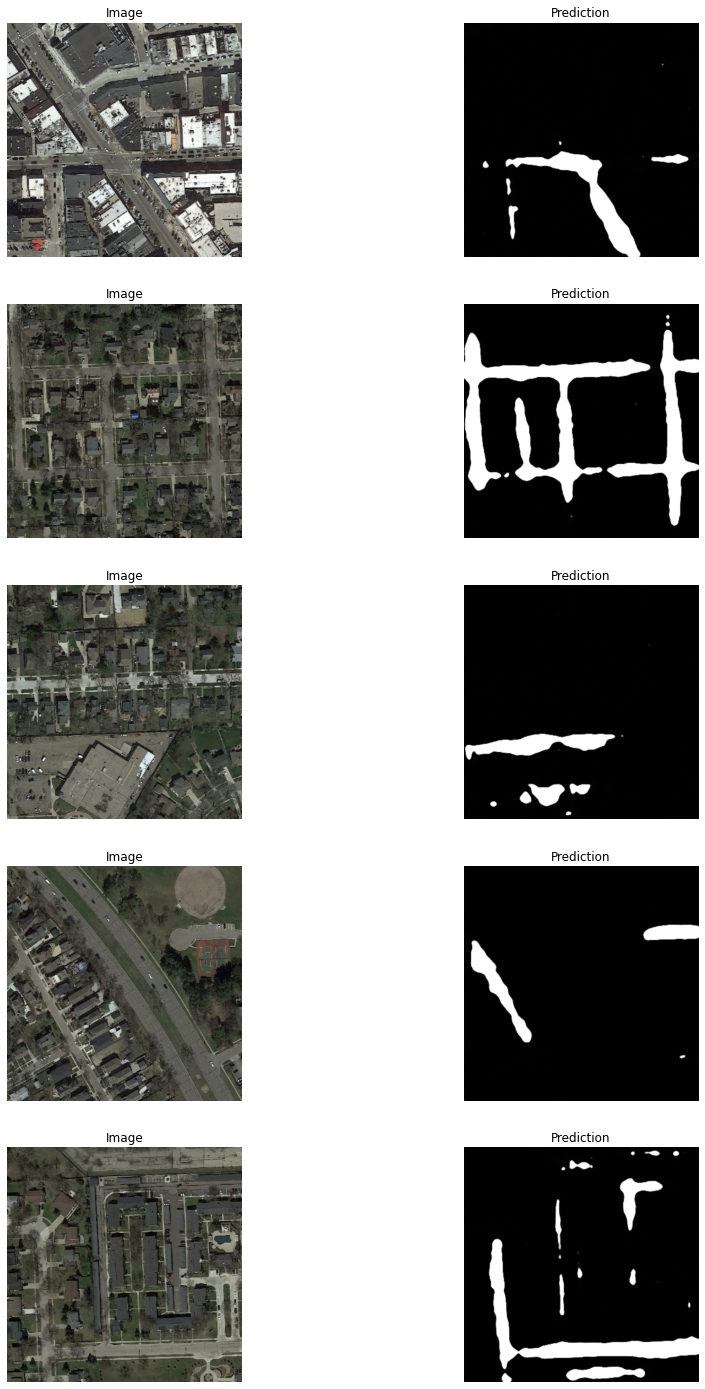

In [117]:
imgs = test_imgs
msks = resized_preds

num_samples = 5

f = plt.figure(figsize= (15, 25))
for i in range(1, num_samples*2, 2):
  img = np.random.randint(msks.shape[0])

  f.add_subplot(num_samples, 2, i)
  imshow(resize(imgs[img], (TEST_HEIGHT, TEST_WIDTH)))
  plt.title("Image")
  plt.axis('off')

  f.add_subplot(num_samples, 2, i+1)
  imshow(msks[img], cmap= 'gray')
  plt.title("Prediction")
  plt.axis('off')